In [ ]:
# NBA Salary Prediction Using Statistical Modeling

## Business Question

Can player performance metrics explain NBA salary levels?

This project compares multiple regression approaches (OLS, Ridge, Lasso, PCR, PLS)
to evaluate predictive performance and interpret salary drivers.


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm


ModuleNotFoundError: No module named 'statsmodels'

In [3]:
df= pd.read_csv('UTF-8NBA_Data.csv')
df = df.dropna()
df.head()

,player,team,POS,GP,MIN,PTS,FGM,FGA,FG%,3PM,...,FT%,REB,AST,STL,BLK,TO,DD2,TD3,year,salary
0,Luka Doncic,DAL,PG,70,37.5,33.9,11.5,23.6,48.7,4.1,...,78.6,9.2,9.8,1.4,0.5,4.0,49,21,2023,40064220
1,Giannis Antetokounmpo,MIL,PF,73,35.2,30.4,11.5,18.8,61.1,0.5,...,65.7,11.5,6.5,1.2,1.1,3.4,57,10,2023,45640084
2,Shai Gilgeous-Alexander,OKC,PG,75,34.0,30.1,10.6,19.8,53.5,1.3,...,87.4,5.5,6.2,2.0,0.9,2.2,8,0,2023,33386850
3,Jalen Brunson,NY,PG,77,35.4,28.7,10.3,21.4,47.9,2.7,...,84.7,3.6,6.7,0.9,0.2,2.4,9,0,2023,26346666
4,Kevin Durant,PHX,PF,75,37.2,27.1,10.0,19.1,52.3,2.2,...,85.6,6.6,5.0,0.9,1.2,3.3,14,1,2023,47649433


## Exploratory Data Analysis (EDA)

Before modeling, we examine:

1. Salary distribution  
2. Correlation between performance metrics and salary  
3. Multicollinearity between predictors  
4. Linearity assumptions


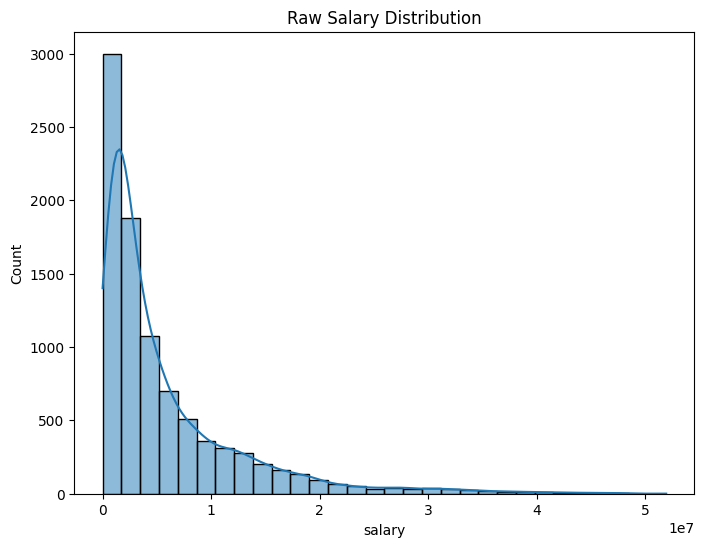

In [4]:
#Salary distribution
plt.figure(figsize=(8,6))
sns.histplot(df['salary'], bins=30, kde=True)
plt.title("Raw Salary Distribution")
plt.show()


Salary distribution is heavily right-skewed with a long tail of very high earners.

In [5]:
#Apply Log Transformation
df['log_salary'] = np.log(df['salary'])


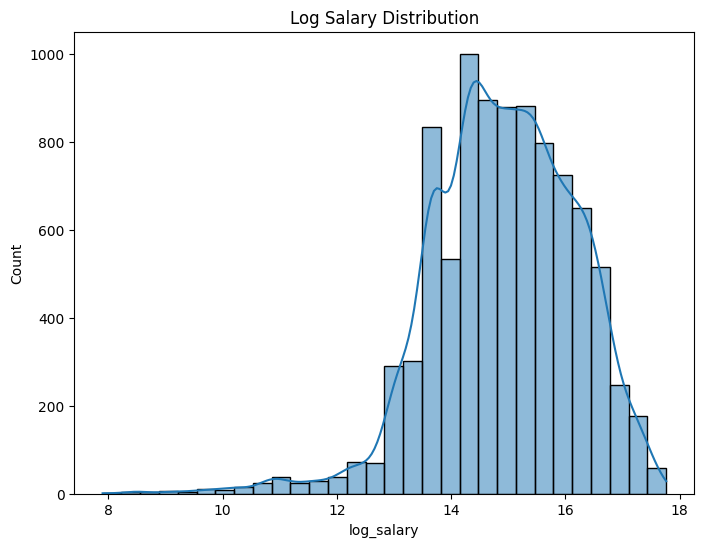

In [6]:
plt.figure(figsize=(8,6))
sns.histplot(df['log_salary'], bins=30, kde=True)
plt.title("Log Salary Distribution")
plt.show()


Log transformation reduces skewness and makes the distribution closer to normal.

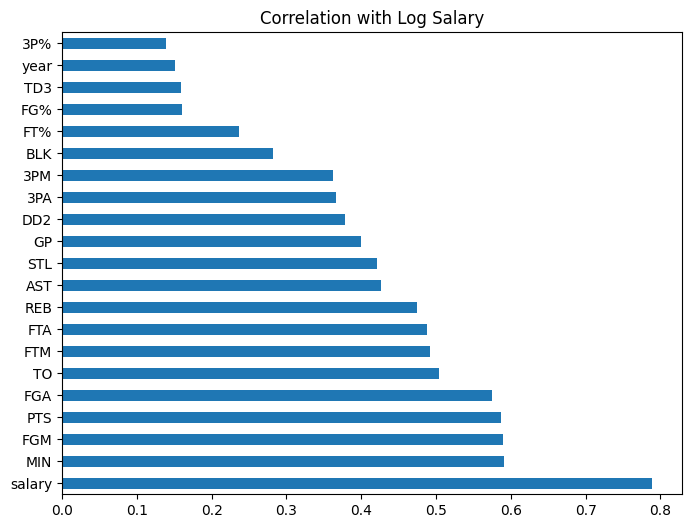

In [7]:
#Correlation with Target
corr_matrix = df.select_dtypes(include=[np.number]).corr()
corr_with_salary = corr_matrix['log_salary'].drop('log_salary').sort_values(ascending=False)

plt.figure(figsize=(8,6))
corr_with_salary.plot(kind="barh")
plt.title("Correlation with Log Salary")
plt.show()


### Interpretation

Playing time (MIN) and offensive production metrics (FGM, PTS, FGA) show the strongest positive correlation with salary.

This suggests that salary is largely driven by player usage and scoring contribution.

Rebounds and assists also contribute meaningfully, indicating that overall game involvement influences compensation.



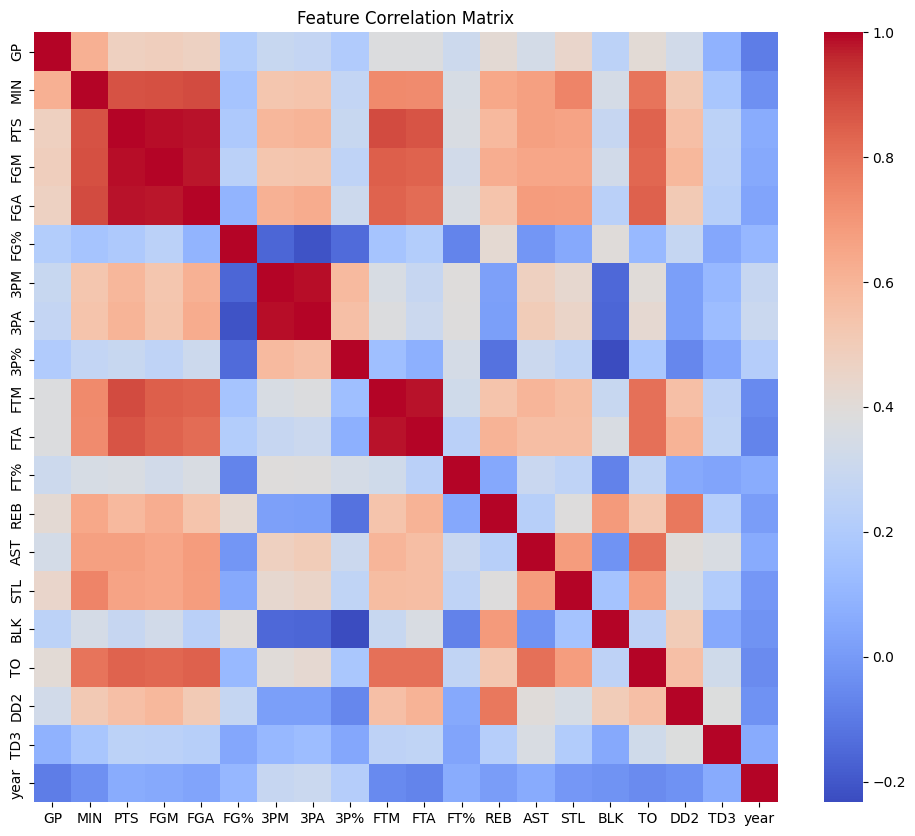

In [8]:
#Multicollinearity Check
features_only = df.drop(columns=['salary','log_salary'], errors='ignore')
features_only = features_only.select_dtypes(include=[np.number])

plt.figure(figsize=(12,10))
sns.heatmap(features_only.corr(), cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()


### Multicollinearity Assessment

Several offensive metrics (PTS, FGM, FGA) show strong positive correlations, 
which is expected due to their mathematical relationships.

Similarly, FTM and FTA, as well as 3PM and 3PA, are highly correlated.

This indicates multicollinearity within the feature set.

Regularized models (Ridge and Lasso) are therefore appropriate 
to stabilize coefficients and potentially improve generalization.


## Train-Test Split & Feature Scaling
Removed non-numeric identifiers (player, team, position)
To evaluate model performance fairly, the dataset is split into:

80% Training Set → used to fit the models
20% Test Set → used to evaluate generalization performance
Feature scaling is applied using StandardScaler to ensure that all variables contribute equally to regularized models (Ridge, Lasso), since these methods are sensitive to feature magnitude.



In [9]:
# Define target and predictors
y = df['log_salary']
X = df.drop(columns=['salary', 'log_salary', 'player', 'team', 'POS'], errors='ignore')

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)



Train size: (7298, 20)
Test size: (1825, 20)


## OLS Regression (Baseline Model)

We first train a standard linear regression model 
to establish a performance baseline.


In [15]:
# Train OLS using sklearn
ols_model = LinearRegression()
ols_model.fit(X_train_scaled, y_train)

# Predictions
ols_preds = ols_model.predict(X_test_scaled)

# Evaluation
ols_mse = mean_squared_error(y_test, ols_preds)
ols_r2 = r2_score(y_test, ols_preds)

print("OLS Test MSE:", round(ols_mse, 4))
print("OLS Test R²:", round(ols_r2, 4))


OLS Test MSE: 0.9534
OLS Test R²: 0.4265


## Ridge Regression

Ridge regression introduces L2 regularization to reduce
coefficient variance in the presence of multicollinearity.


In [10]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge = Ridge()

param_grid = {'alpha': np.logspace(-4, 4, 50)}

ridge_cv = GridSearchCV(ridge, param_grid, cv=5)
ridge_cv.fit(X_train_scaled, y_train)

best_ridge = ridge_cv.best_estimator_

ridge_preds = best_ridge.predict(X_test_scaled)

ridge_mse = mean_squared_error(y_test, ridge_preds)
ridge_r2 = r2_score(y_test, ridge_preds)

print("Best alpha:", ridge_cv.best_params_['alpha'])
print("Ridge Test MSE:", round(ridge_mse, 4))
print("Ridge Test R²:", round(ridge_r2, 4))


Best alpha: 16.768329368110066
Ridge Test MSE: 0.9521
Ridge Test R²: 0.4273


## Lasso Regression

Lasso applies L1 regularization, which can shrink some coefficients to exactly zero.
This can perform feature selection and simplify the model.


In [12]:
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(
    alphas=np.logspace(-4, 1, 30),
    cv=5,
    max_iter=200000,
    n_jobs=-1,
    random_state=42
)
lasso_cv.fit(X_train_scaled, y_train)

lasso_preds = lasso_cv.predict(X_test_scaled)

lasso_mse = mean_squared_error(y_test, lasso_preds)
lasso_r2 = r2_score(y_test, lasso_preds)

print("Best alpha:", lasso_cv.alpha_)
print("Lasso Test MSE:", round(lasso_mse, 4))
print("Lasso Test R²:", round(lasso_r2, 4))


Best alpha: 0.0001
Lasso Test MSE: 0.9525
Lasso Test R²: 0.4271


In [13]:
coef_series = pd.Series(lasso_cv.coef_, index=X.columns)
selected = coef_series[coef_series != 0].sort_values(key=np.abs, ascending=False)

print("Number of selected features:", (coef_series != 0).sum())
print("\nSelected features:")
print(selected)


Number of selected features: 20

Selected features:
PTS     0.664849
REB     0.356043
AST     0.230860
FTA    -0.175369
DD2    -0.153627
year    0.153422
3PM     0.152783
GP      0.138274
FGM    -0.136216
3PA    -0.114303
MIN     0.112096
FGA    -0.111580
BLK     0.080175
FTM     0.076204
3P%    -0.073318
STL    -0.062541
FG%    -0.058193
TO     -0.034481
FT%     0.033424
TD3    -0.000233
dtype: float64


### Lasso Interpretation

Lasso retained most features, suggesting that salary is influenced by
multiple performance metrics rather than a small subset.

Points scored (PTS) shows the strongest positive association with salary,
followed by rebounds (REB) and assists (AST).

Some correlated variables (e.g., FGA, FGM, FTA) display negative coefficients,
which reflects conditional relationships due to multicollinearity.

This indicates that salary depends on overall contribution,
not isolated raw counts.


In [16]:
results = pd.DataFrame({
    "Model": ["OLS", "Ridge", "Lasso"],
    "MSE": [ols_mse, ridge_mse, lasso_mse],
    "R2": [ols_r2, ridge_r2, lasso_r2]
})

results


,Model,MSE,R2
0,OLS,0.953411,0.426536
1,Ridge,0.952059,0.427350
2,Lasso,0.952482,0.427095


## Final Model Comparison & Conclusion

All models achieved similar predictive performance.

Ridge and Lasso provided marginal improvements over OLS,
indicating that while multicollinearity exists,
it does not significantly degrade generalization.

The model explains approximately 43% of salary variance,
suggesting that performance metrics are important
but do not fully determine player compensation.

Non-performance factors likely contribute substantially
to salary variation.

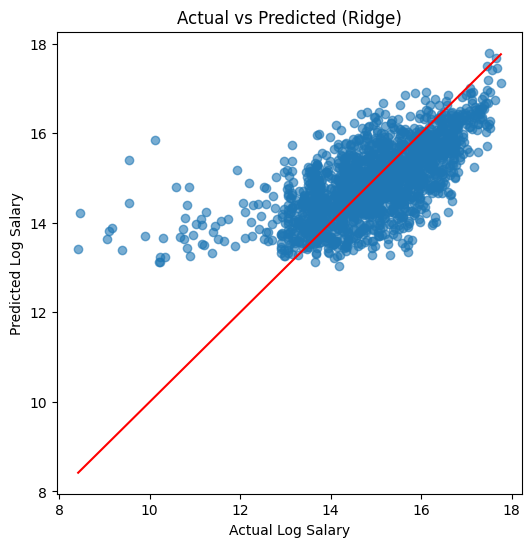

In [17]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, ridge_preds, alpha=0.6)
plt.xlabel("Actual Log Salary")
plt.ylabel("Predicted Log Salary")
plt.title("Actual vs Predicted (Ridge)")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color="red")
plt.show()


### Prediction Analysis

The model captures the overall salary trend,
but tends to underestimate very high salaries
and overestimate low salaries.

This regression-to-the-mean effect suggests that
extreme contracts are influenced by additional
non-performance factors not included in the dataset.


## Business Insights

### 1. Performance strongly influences salary — but does not fully determine it.

The model explains approximately 43% of salary variance, indicating that 
on-court performance metrics such as points (PTS), rebounds (REB), and assists (AST) 
are significant salary drivers.

However, more than half of salary variability remains unexplained, suggesting 
that non-performance factors play a substantial role.

---

### 2. Scoring is the dominant performance signal.

Among all features, total points scored (PTS) consistently shows the strongest 
association with salary across models.

This suggests that offensive production remains the primary measurable 
b